In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder,FunctionTransformer

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('../data/cleaned_dataset.csv')

In [4]:
# target feature and redundant features to be dropped 

target_feature = 'Time_taken (min)'
drop_features = ['ID', 'Time_Orderd', 'Order_Date', 'Type_of_order', target_feature]

In [5]:
numerical_columns = ['Delivery_person_Age', 'Delivery_person_Ratings', 
                     "Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude", "Delivery_location_longitude", 'Time_Order_picked']
categorical_columns = ['Weather_conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_vehicle', 'multiple_deliveries',	'Festival', 'City']

In [6]:
Weather_conditions_map={'Fog':3,'Cloudy':3,'Stormy':2,'Sandstorms':2,'Windy':2,'Sunny':1}
Road_traffic_density_map={'Jam':4, 'High':3, 'Medium':2, 'Low':1}
Type_of_vehicle_map={'motorcycle':2, 'bicycle':2, 'scooter':1, 'electric_scooter':1}
Festival_map={'Yes':1, 'No':0}
City_map={'Semi-Urban':3, 'Metropolitian':2, 'Urban':1}

In [7]:
from geopy.distance import geodesic

In [8]:
def timeDist_transform(df: pd.DataFrame):
    """function to convert coordinates to distance in kilometres"""

    def geo(sample):
        if sample.notnull().all():
            return geodesic(
                    (sample["Restaurant_latitude"], sample["Restaurant_longitude"]), 
                    (sample["Delivery_location_latitude"], sample["Delivery_location_longitude"])).km
        else:
            return np.nan    # passing as NaN if any coordinate is null

    df["Distance"] = df.apply(geo, axis=1) 
    df = df.drop(columns=["Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude", "Delivery_location_longitude"])
    df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'], errors='coerce', format='%H:%M').dt.hour
    return df

def add_dist(self, feature_names):
    coordinates = ["Restaurant_latitude", "Restaurant_longitude", 
                   "Delivery_location_latitude", "Delivery_location_longitude"]
    features  = [i for i in feature_names if i not in coordinates]
    features.append('Distance')
    return features

In [9]:
def mapper(df :pd.DataFrame):
    '''mapping function for the categorical columns'''

    df['Weather_conditions'] = df['Weather_conditions'].map(Weather_conditions_map)
    df['Road_traffic_density'] = df['Road_traffic_density'].map(Road_traffic_density_map)
    df['Type_of_vehicle'] = df['Type_of_vehicle'].map(Type_of_vehicle_map)
    df['Festival'] = df['Festival'].map(Festival_map)
    df['City'] = df['City'].map(City_map)
    return df

In [10]:
# Delivery person ID pipeline
id_pipeline = Pipeline(
    steps=[
        ('target_encoder_id', TargetEncoder(target_type='continuous')),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

# Numerical pipeline
numerical_pipeline = Pipeline(
    steps=[
        ('time_distance', FunctionTransformer(timeDist_transform, feature_names_out=add_dist)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# categorical pipeline
categorical_pipeline = Pipeline(
    steps=[
        ('mapper', FunctionTransformer(mapper, feature_names_out='one-to-one')),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer([
    ('id', id_pipeline, ['Delivery_person_ID']),
    ('num_pipe', numerical_pipeline, numerical_columns),
    ('cat_pipe', categorical_pipeline, categorical_columns)
])

In [11]:
# train test split
train_df, test_df = train_test_split(df, test_size=0.30, random_state=3)

In [12]:
X_train = train_df.drop(columns=drop_features)
y_train = train_df[target_feature]

X_test = test_df.drop(columns=drop_features)
y_test = test_df[target_feature]

In [13]:
Weather_conditions_map={'Fog':3,'Cloudy':3,'Stormy':2,'Sandstorms':2,'Windy':2,'Sunny':1}
Road_traffic_density_map={'Jam':4, 'High':3, 'Medium':2, 'Low':1}
Type_of_vehicle_map={'motorcycle':2, 'bicycle':2, 'scooter':1, 'electric_scooter':1}
Festival_map={'Yes':1, 'No':0}
City_map={'Semi-Urban':3, 'Metropolitian':2, 'Urban':1}

In [14]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train, y=y_train), columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

In [15]:
X_train.head()

,id__Delivery_person_ID,num_pipe__Delivery_person_Age,num_pipe__Delivery_person_Ratings,num_pipe__Time_Order_picked,num_pipe__Distance,cat_pipe__Weather_conditions,cat_pipe__Road_traffic_density,cat_pipe__Vehicle_condition,cat_pipe__Type_of_vehicle,cat_pipe__multiple_deliveries,cat_pipe__Festival,cat_pipe__City
0,0.090174,-0.453229,0.855546,0.986695,0.489118,-0.258872,-1.095892,-1.225324,0.851462,-1.330184,-0.141143,-1.858024
1,-1.943181,-0.099473,1.180473,1.220803,1.912910,-0.258872,-1.095892,-0.030284,0.851462,0.442337,-0.141143,-1.858024
2,-1.958540,0.077405,-0.119237,-1.822603,-1.219380,1.212181,-1.095892,-0.030284,0.851462,0.442337,-0.141143,0.514611
3,0.869204,0.784917,0.855546,0.284370,0.774445,1.212181,1.307984,-1.225324,0.851462,2.214859,-0.141143,0.514611
4,0.014167,0.961795,0.530618,0.986695,0.774379,-0.258872,-1.095892,-0.030284,-1.174450,0.442337,-0.141143,0.514611


In [16]:
X_test.head()

,id__Delivery_person_ID,num_pipe__Delivery_person_Age,num_pipe__Delivery_person_Ratings,num_pipe__Time_Order_picked,num_pipe__Distance,cat_pipe__Weather_conditions,cat_pipe__Road_traffic_density,cat_pipe__Vehicle_condition,cat_pipe__Type_of_vehicle,cat_pipe__multiple_deliveries,cat_pipe__Festival,cat_pipe__City
0,-0.616496,-0.983863,0.855546,0.986695,-0.921762,-1.729925,-1.095892,-0.030284,0.851462,0.442337,-0.141143,0.514611
1,-0.530054,0.254283,0.205690,-2.290819,-1.215479,1.212181,-1.095892,-0.030284,0.851462,0.442337,-0.141143,0.514611
2,0.393488,-0.099473,0.205690,0.050262,-0.357581,-1.729925,-0.294600,-0.030284,-1.174450,0.442337,-0.141143,-1.858024
3,0.227571,0.961795,0.205690,-0.886170,-0.668092,-1.729925,0.506692,-0.030284,-1.174450,-1.330184,-0.141143,0.514611
4,-0.550298,0.077405,-1.094020,-0.183846,0.771638,1.212181,-0.294600,-0.030284,0.851462,0.442337,-0.141143,0.514611


In [17]:
def model_evaluation(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2_squared = r2_score(true, predicted)
    return rmse, mae, r2_squared

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
import warnings
warnings.filterwarnings('ignore')

Model Name: LinearRegression
Model Training Performance
RMSE: 6.185721769244484
MAE: 4.8935239543332045
R2 score: 56.706894793464755


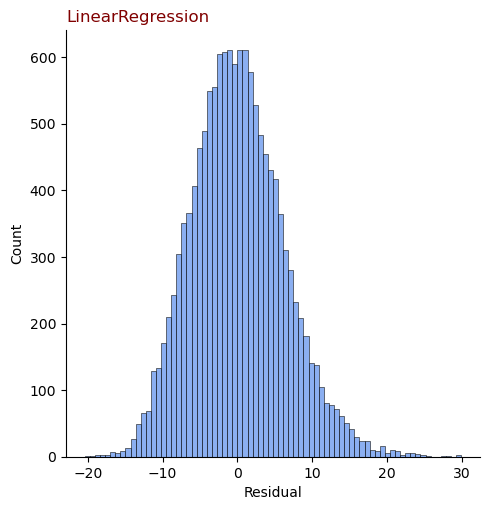


Model Name: Lasso
Model Training Performance
RMSE: 6.68093988687665
MAE: 5.31497837414664
R2 score: 49.49747392786791


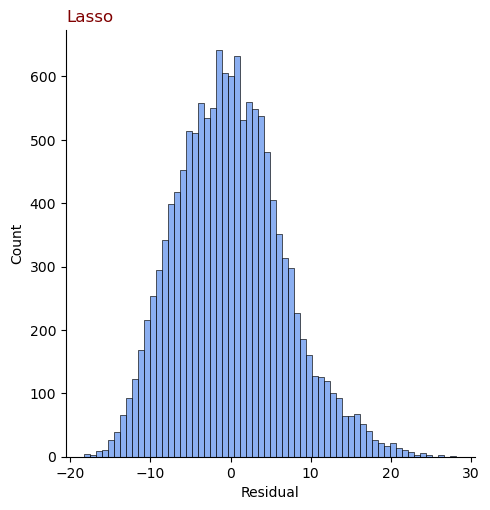


Model Name: Ridge
Model Training Performance
RMSE: 6.185722519195161
MAE: 4.8935250145501055
R2 score: 56.70688429583919


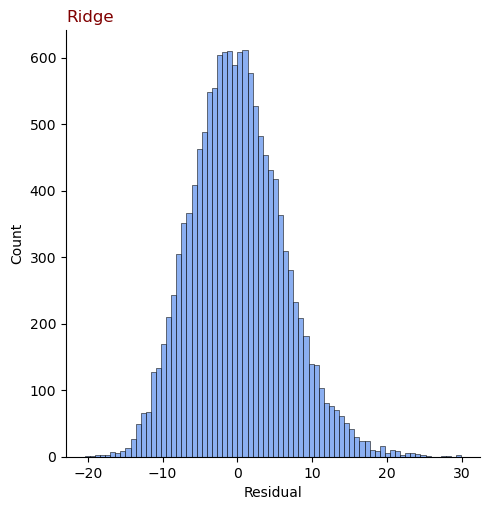


Model Name: ElasticNet
Model Training Performance
RMSE: 6.750876608536838
MAE: 5.3922510649219
R2 score: 48.434609202775


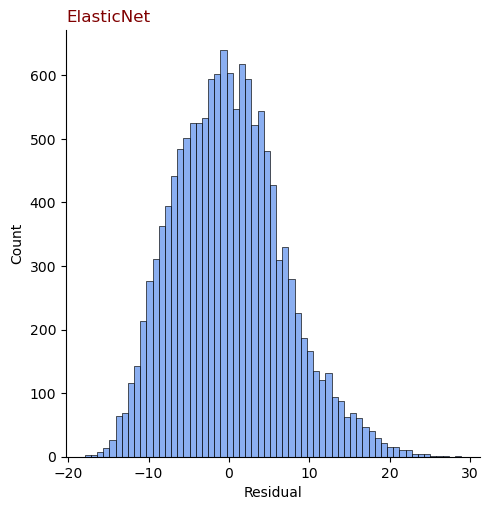

In [24]:
# Training multiple models

models = {
    'LinearRegression' : LinearRegression(),
    'Lasso' : Lasso(),
    'Ridge' : Ridge(),
    'ElasticNet' : ElasticNet()
}

for i in models:
    model = models[i]
    model.fit(X_train, y_train)

    # predictions
    y_pred = model.predict(X_test)

    rmse, mae, r2_squared = model_evaluation(y_test, y_pred)

    print(f'Model Name: {i}')
    print('Model Training Performance')
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 score: {r2_squared*100}")

    res=y_test-y_pred

    sns.displot(res, color='cornflowerblue')
    plt.xlabel('Residual')
    plt.title(i, loc='left', color='maroon')
    plt.show()
    
    print('='*100,'\n')

In [25]:
# The resuduals of the models are distributed normally, which indicates a completed model

In [21]:
# Ordinary linear regression has the best r2 score
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [22]:
for i,j in zip(regression.feature_names_in_, regression.coef_):
    print(f'{i} : {j}')
print(f'intercept : {regression.intercept_}')

id__Delivery_person_ID : 0.017028783573630885
num_pipe__Delivery_person_Age : 2.2150534075583193
num_pipe__Delivery_person_Ratings : -2.2330884930792347
num_pipe__Time_Order_picked : -0.49782625362788274
num_pipe__Distance : 2.018834374360799
cat_pipe__Weather_conditions : 2.0526217049282334
cat_pipe__Road_traffic_density : 2.8679384613771575
cat_pipe__Vehicle_condition : -1.4890174793885675
cat_pipe__Type_of_vehicle : 0.28649709001885415
cat_pipe__multiple_deliveries : 1.728693994013585
cat_pipe__Festival : 1.4181812719127902
cat_pipe__City : 0.9606134529950349
intercept : 26.289747213063272
